In [1]:
%load_ext autoreload
%autoreload 2

In [232]:
import numpy as np
from ipywidgets import HBox, VBox, Label, Layout, Button, Output
from IPython.display import display
from functools import partial
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import math
import copy
from enum import Enum
from abc import ABC, abstractmethod
from dataclasses import dataclass
from base import View, Agent, Mark, Action, GameState
from Game import Game
from QLearningApproximationAgent import QLearningApproximationAgent
from EpsilonGreedyPolicy import EpsilonGreedyPolicy
from NumRowsFeatures import NumRowsFeatures
import logging
from CartNumRowsFeatures import CartNumRowsFeatures
import pandas as pd

In [13]:
class JupyterView(View):
    def __init__(self, update_on_end: bool = False):
        self.update_on_end = update_on_end
        self.out = Output()
    
    def on_click(self, row, column, button):
        self.disable_all_buttons()
        self.turn_callback(Action(row, column))
    
    def update(self, state):
        if not self.update_on_end or state.is_game_end:
            label = Label()
            if state.is_game_end:
                if state.winner == Mark.NO:
                    label.value = "Draw!"
                else:
                    label.value = state.winner.name + ' wins!'
            else:
                label.value = state.current_player.name + "'s turn"

            h, w = state.board.shape
            self.buttons = []
            buttons = []

            for r in range(h):
                line = []
                for c in range(w):
                    button = Button(
                        description='',
                        layout=Layout(width='20px', height='20px', padding='0px')
                    )

                    button.on_click(partial(self.on_click, r, c))

                    if state.board[r][c] == Mark.X.value:
                        button.description = Mark.X.name
                        button.disabled = True
                    elif state.board[r][c] == Mark.O.value:
                        button.description = Mark.O.name
                        button.disabled = True
                    elif state.is_game_end:
                        button.disabled = True

                    line.append(button)
                    self.buttons.append(button)

                buttons.append(HBox(line))

            self.out.clear_output()
            with self.out:
                display(VBox([label, VBox(buttons)]))
        
    def disable_all_buttons(self):
        for b in self.buttons:
            b.disabled = True
    


In [14]:
class JupyterHumanAgent(Agent):
    def __init__(self):
        pass
    
    def get_action(self, state):
        return None
    
    def win(self, state):
        pass
    
    def loss(self, state):
        pass
    
    def draw(self, state):
        pass

In [15]:
g = Game(player1=JupyterHumanAgent(), player2=JupyterHumanAgent(), view=JupyterView())
g.view.out

Output()

In [ ]:
max_row = 5
num_feat = ((((max_row - 1) * 2) - 1) * 2) + 1
theta = np.zeros(num_feat)
agent1 = QLearningApproximationAgent(0.5, 0.5, EpsilonGreedyPolicy(0.05), theta=theta)
agent2 = QLearningApproximationAgent(0.5, 0.5, EpsilonGreedyPolicy(0.05), theta=theta)
g = Game(player1=agent1, player2=agent2, view=JupyterView(update_on_end=True))
g.view.out

In [ ]:
max_row = 5
feat_model = NumRowsFeatures(row=5)
#feat_model = CartNumRowsFeatures(row=5)
num_feat = feat_model.features_count() + 1 
theta = np.zeros(num_feat)
for i in tqdm(range(10)):
    print(f'Game {i}')
    print(f'Theta1 {theta}')
    
    agent1 = QLearningApproximationAgent(0.5, 0.5, EpsilonGreedyPolicy(0.05), theta=theta, features_model=feat_model, inf_field=False)
    agent2 = QLearningApproximationAgent(0.5, 0.5, EpsilonGreedyPolicy(0.05), theta=theta, features_model=feat_model, inf_field=False)
    g = Game(player1=agent1, player2=agent2, view=None, m=15, n=15)


In [199]:
log = pd.read_csv('15.csv', sep=';')
log.tail(5)

,game_no,turn,player,height,width,learn_params,row,column
103634,999,64,X,15,15,"[-2.0410077422772237, -0.32945274580644796, -0...",10,10
103635,999,65,O,15,15,"[-2.0408374730532826, -0.32881984116443175, -0...",11,13
103636,999,66,X,15,15,"[-2.0412628629883622, -0.3286761386505204, -0....",10,9
103637,999,67,O,15,15,"[-2.0410233889937897, -0.32775704246577636, -0...",13,6
103638,999,68,X,15,15,"[-2.0441405714625684, -0.326450975595147, -0.2...",10,8


In [207]:
gelog = log.groupby('game_no').tail(1)
gelog.tail()

,game_no,turn,player,height,width,learn_params,row,column
103338,995,81,O,15,15,"[-2.044183758052597, -0.5000473392893885, -0.1...",4,14
103395,996,56,X,15,15,"[-2.0321400060376535, -0.49824057640755176, -0...",3,6
103476,997,80,X,15,15,"[-2.0309191159343407, -0.4203427022551607, -0....",3,8
103569,998,92,X,15,15,"[-2.035965767145691, -0.31214466024597387, -0....",5,6
103638,999,68,X,15,15,"[-2.0441405714625684, -0.326450975595147, -0.2...",10,8


In [208]:
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []

for i, row in gelog.iterrows():
    if row['turn'] == 200:
        draws += 1
    elif row['player'] == 'X':
        x_wins += 1
    else:
        o_wins += 1
        
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

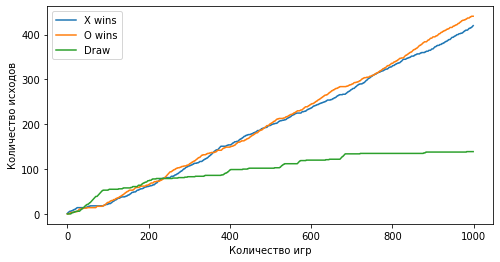

In [209]:
plt.figure(figsize=(8,4))
plt.xlabel('Количество игр')
plt.ylabel('Количество исходов')
#plt.xlim([0,600])
#plt.ylim([0,300])
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

In [210]:
gblog = log.groupby('game_no').head(1)
gblog.tail()

,game_no,turn,player,height,width,learn_params,row,column
103257,995,0,X,15,15,"[-2.0423601603677946, -0.49726771489334015, -0...",2,8
103339,996,0,X,15,15,"[-2.0417550606136317, -0.4976186418504228, -0....",2,11
103396,997,0,X,15,15,"[-2.032455543509103, -0.424315348981503, -0.18...",2,2
103477,998,0,X,15,15,"[-2.0311889121928206, -0.3028529413590331, -0....",13,3
103570,999,0,X,15,15,"[-2.0367151410383384, -0.31292109143314994, -0...",9,4


In [211]:
for i in range(17):
    gblog['theta'+str(i)] = gblog['learn_params'].apply(lambda x: eval(x)[i])

/home/vvodan/.pyenv/versions/default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [212]:
gblog.tail(5)

,game_no,turn,player,height,width,learn_params,row,column,theta0,theta1,...,theta7,theta8,theta9,theta10,theta11,theta12,theta13,theta14,theta15,theta16
103257,995,0,X,15,15,"[-2.0423601603677946, -0.49726771489334015, -0...",2,8,-2.042360,-0.497268,...,0.214560,0.875463,-0.077408,-16.218483,-0.267564,0.263109,-0.108093,-15.831085,-0.285673,-0.084366
103339,996,0,X,15,15,"[-2.0417550606136317, -0.4976186418504228, -0....",2,11,-2.041755,-0.497619,...,0.213518,0.871576,-0.082880,-16.220251,-0.269054,0.168404,-0.057457,-15.832575,-0.285973,-0.085660
103396,997,0,X,15,15,"[-2.032455543509103, -0.424315348981503, -0.18...",2,2,-2.032456,-0.424315,...,0.211066,0.826838,-0.038534,-16.259149,-0.271408,0.317376,-0.007068,-15.834929,-0.278232,-0.087818
103477,998,0,X,15,15,"[-2.0311889121928206, -0.3028529413590331, -0....",13,3,-2.031189,-0.302853,...,0.229349,0.677257,-0.004251,-16.292890,-0.270661,0.275533,-0.080180,-15.868670,-0.279313,-0.086880
103570,999,0,X,15,15,"[-2.0367151410383384, -0.31292109143314994, -0...",9,4,-2.036715,-0.312921,...,0.230501,0.663819,0.024306,-16.333217,-0.269509,0.179543,0.036829,-15.867518,-0.277704,-0.085536


In [213]:
theta = gblog.loc[:][['theta'+str(i) for i in range(17)]]
theta.tail(5)

,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,theta11,theta12,theta13,theta14,theta15,theta16
103257,-2.042360,-0.497268,-0.138379,0.674362,36.031513,-0.293718,0.077765,0.214560,0.875463,-0.077408,-16.218483,-0.267564,0.263109,-0.108093,-15.831085,-0.285673,-0.084366
103339,-2.041755,-0.497619,-0.139889,0.636294,36.071442,-0.158197,0.020049,0.213518,0.871576,-0.082880,-16.220251,-0.269054,0.168404,-0.057457,-15.832575,-0.285973,-0.085660
103396,-2.032456,-0.424315,-0.182688,0.651216,36.102350,-0.280710,-0.008969,0.211066,0.826838,-0.038534,-16.259149,-0.271408,0.317376,-0.007068,-15.834929,-0.278232,-0.087818
103477,-2.031189,-0.302853,-0.216239,0.669952,36.135215,-0.241177,0.062074,0.229349,0.677257,-0.004251,-16.292890,-0.270661,0.275533,-0.080180,-15.868670,-0.279313,-0.086880
103570,-2.036715,-0.312921,-0.256507,0.674738,36.169312,-0.171358,-0.040815,0.230501,0.663819,0.024306,-16.333217,-0.269509,0.179543,0.036829,-15.867518,-0.277704,-0.085536


In [214]:
theta_diff = theta.diff()
theta_diff.columns = ['td'+str(i) for i in range(17)]
theta_diff = theta_diff.fillna(0)
theta_diff['abs_sum'] = theta_diff.abs().sum(axis=1)
theta_diff.tail(5)

,td0,td1,td2,td3,td4,td5,td6,td7,td8,td9,td10,td11,td12,td13,td14,td15,td16,abs_sum
103257,0.001148,0.042449,-0.000185,0.003699,0.040241,0.005111,0.134847,-0.042139,-0.005951,-0.005620,-0.042139,-0.001122,0.000285,-0.133454,0.040241,0.000181,-0.000998,0.499809
103339,0.000605,-0.000351,-0.001510,-0.038068,0.039928,0.135521,-0.057715,-0.001042,-0.003887,-0.005473,-0.001767,-0.001490,-0.094705,0.050636,-0.001490,-0.000300,-0.001294,0.435784
103396,0.009300,0.073303,-0.042799,0.014922,0.030908,-0.122513,-0.029018,-0.002452,-0.044738,0.044346,-0.038899,-0.002354,0.148972,0.050389,-0.002354,0.007741,-0.002158,0.667166
103477,0.001267,0.121462,-0.033552,0.018737,0.032865,0.039534,0.071043,0.018283,-0.149582,0.034283,-0.033741,0.000748,-0.041843,-0.073112,-0.033741,-0.001081,0.000939,0.705811
103570,-0.005526,-0.010068,-0.040267,0.004786,0.034097,0.069819,-0.102889,0.001152,-0.013438,0.028557,-0.040327,0.001152,-0.095989,0.117008,0.001152,0.001609,0.001343,0.569180


In [218]:
theta = pd.concat([gblog, theta_diff], axis=1)
theta = theta.reset_index(drop=True)
theta.tail(5)

,game_no,turn,player,height,width,learn_params,row,column,theta0,theta1,...,td8,td9,td10,td11,td12,td13,td14,td15,td16,abs_sum
995,995,0,X,15,15,"[-2.0423601603677946, -0.49726771489334015, -0...",2,8,-2.042360,-0.497268,...,-0.005951,-0.005620,-0.042139,-0.001122,0.000285,-0.133454,0.040241,0.000181,-0.000998,0.499809
996,996,0,X,15,15,"[-2.0417550606136317, -0.4976186418504228, -0....",2,11,-2.041755,-0.497619,...,-0.003887,-0.005473,-0.001767,-0.001490,-0.094705,0.050636,-0.001490,-0.000300,-0.001294,0.435784
997,997,0,X,15,15,"[-2.032455543509103, -0.424315348981503, -0.18...",2,2,-2.032456,-0.424315,...,-0.044738,0.044346,-0.038899,-0.002354,0.148972,0.050389,-0.002354,0.007741,-0.002158,0.667166
998,998,0,X,15,15,"[-2.0311889121928206, -0.3028529413590331, -0....",13,3,-2.031189,-0.302853,...,-0.149582,0.034283,-0.033741,0.000748,-0.041843,-0.073112,-0.033741,-0.001081,0.000939,0.705811
999,999,0,X,15,15,"[-2.0367151410383384, -0.31292109143314994, -0...",9,4,-2.036715,-0.312921,...,-0.013438,0.028557,-0.040327,0.001152,-0.095989,0.117008,0.001152,0.001609,0.001343,0.569180


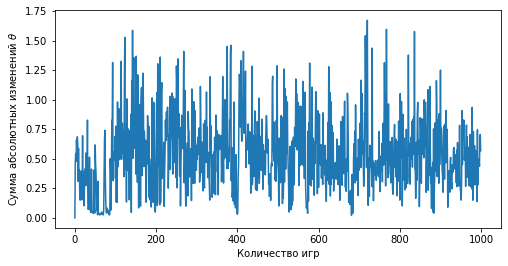

In [222]:
plt.figure(figsize=(8,4))
plt.xlabel('Количество игр')
plt.ylabel(r'Сумма абсолютных изменений $\theta$')
plt.plot(theta['abs_sum'])
plt.show()

In [301]:
gelog.tail(20)

,game_no,turn,player,height,width,learn_params,row,column
102006,980,119,O,15,15,"[-2.1127034009948478, -0.14060849605932485, -0...",8,9
102047,981,40,X,15,15,"[-2.1150524717578993, -0.27444291349385647, -0...",8,0
102113,982,65,O,15,15,"[-2.1157159882138052, -0.3287418443056354, -0....",6,0
102314,983,200,X,15,15,"[-2.11212874567855, -0.40421218975813805, -0.1...",7,6
102420,984,105,O,15,15,"[-2.1073168014872583, -0.3780090112586862, -0....",0,7
102476,985,55,O,15,15,"[-2.1051783083376048, -0.33326267237176366, -0...",1,2
102563,986,86,X,15,15,"[-2.0965696287573277, -0.37236143904045244, -0...",3,9
102608,987,44,X,15,15,"[-2.0959156377104584, -0.5395373946416061, -0....",9,8
102741,988,132,X,15,15,"[-2.084111251536579, -0.614943029388451, -0.17...",13,6
102810,989,68,X,15,15,"[-2.0749587470621695, -0.7281750548867476, -0....",11,8


In [302]:
game_log = log.loc[log['game_no']==993]
game_log.tail(5)

,game_no,turn,player,height,width,learn_params,row,column
103177,993,33,O,15,15,"[-2.0627364675169324, -0.5631294353260671, -0....",2,6
103178,993,34,X,15,15,"[-2.065470132519534, -0.5723561681894254, -0.1...",3,13
103179,993,35,O,15,15,"[-2.058864291885546, -0.5737974425095682, -0.1...",6,10
103180,993,36,X,15,15,"[-2.054647783301315, -0.5645288603372581, -0.1...",3,8
103181,993,37,O,15,15,"[-2.0507979293599967, -0.5606790063959399, -0....",3,7


In [303]:
game_log = game_log.reset_index(drop=True)
game_log

,game_no,turn,player,height,width,learn_params,row,column
0,993,0,X,15,15,"[-2.0640265184033137, -0.5688227489675188, -0....",8,6
1,993,1,O,15,15,"[-2.0640265184033137, -0.5688227489675188, -0....",8,7
2,993,2,X,15,15,"[-2.0640265184033137, -0.5688227489675188, -0....",7,8
3,993,3,O,15,15,"[-2.06383095512014, -0.568824438093765, -0.165...",8,5
4,993,4,X,15,15,"[-2.0638149153868577, -0.5688244538809041, -0....",9,4
5,993,5,O,15,15,"[-2.0637988716475846, -0.5688244696719861, -0....",9,3
6,993,6,X,15,15,"[-2.063782921586815, -0.5688244853708648, -0.1...",9,2
7,993,7,O,15,15,"[-2.063766975554432, -0.5688245010657786, -0.1...",4,5
8,993,8,X,15,15,"[-2.0637510335534426, -0.5688245167567245, -0....",4,4
9,993,9,O,15,15,"[-2.0635227557418108, -0.56882474143961, -0.16...",5,5


In [230]:
v_board = np.full((15,15), ' ')
board = np.zeros((15,15))

In [231]:
feat_model = NumRowsFeatures(row=5)
theta = np.array([-2.0441405714625684, -0.326450975595147, -0.25331035065294294, 0.6763756236082743, 36.1722596773075, -0.19358975032876868, -0.04520249822590173,
                  0.23274268398409093, 0.6279499116480793, 0.027023863707913723, -16.330268976495976, -0.2665606082521952, 0.1666772223154195, 0.018204062012422733,
                  -15.864569939264479, -0.27524700830101867, -0.0823975894292377])
agent = QLearningApproximationAgent(0.5, 0.5, EpsilonGreedyPolicy(0.05), theta=theta, features_model=feat_model, inf_field=True)

In [241]:
np.set_printoptions(precision=2)

In [250]:
def print_q_table(t):
    w = 7
    for r in t:
        line = ''
        for e in r:
            tp = str(e)
            ltp = len(tp)
            if ltp < w:
                tp += ' ' * (w - ltp)
            line += tp
        print(line)

In [304]:
board = np.zeros((15,15))
states = []
q_tables = []
for i, r in game_log.iterrows():
    b = board.copy()
    curr_p = Mark[r['player']]
    new_state = GameState(b, curr_p, False, Mark['NO'])
    states.append(new_state)
    actions = agent.get_possible_actions(new_state)
    Q_table = new_state.board.copy().astype(dtype=np.object)
    Q_table[Q_table == Mark.X.value] = Mark.X.name
    Q_table[Q_table == Mark.O.value] = Mark.O.name
    for a in actions:
        a.new_board = new_state.board.copy()
        a.new_board[a.action.row, a.action.col] = new_state.current_player.value
        a.new_features = np.insert(agent.features_model.get_features(GameState(a.new_board, new_state.current_player, new_state.is_game_end, new_state.winner)), 0, 1)
        a.new_Q_value = np.dot(agent.theta, a.new_features)
        Q_table[a.action.row, a.action.col] = np.around(a.new_Q_value, 2)
    q_tables.append(Q_table)
    print(f'State: {i}')
    print_q_table(Q_table)
    print(f'Player {r.player}: place to {r.row}, {r.column}')
    board[r['row'], r['column']] = curr_p.value

State: 0
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   -2.4   
-2.4   -2.4   -2.4   -2.4   -2.4   -2

In [292]:
def heatmap_q_values(qt, player=''):
    data = qt.copy()
    data[data == Mark.X.name] = np.nan
    data[data == Mark.O.name] = np.nan
    data = data.astype(dtype=np.float)

    fig, ax = plt.subplots(figsize=(6,4))
    heatmap = ax.pcolor(data, cmap=plt.cm.plasma, vmin=np.nanmin(data), vmax=np.nanmax(data))
    heatmap.cmap.set_under('white')
    bar = fig.colorbar(heatmap)
    h, w = qt.shape
    for y in range(h):
        for x in range(w):
            if qt[y, x] in ['X', 'O']:
                plt.text(x + 0.5, y + 0.5, qt[y, x], horizontalalignment='center', verticalalignment='center')
    ax.set_title('Ход: ' + player)
    plt.show() 
    

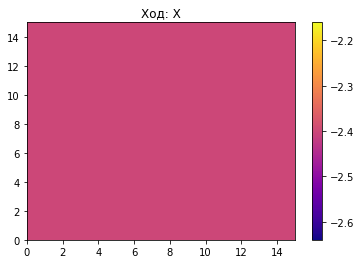

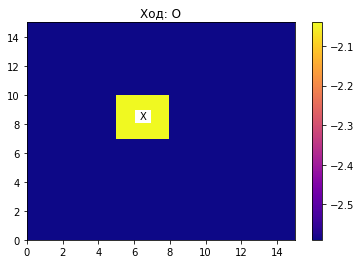

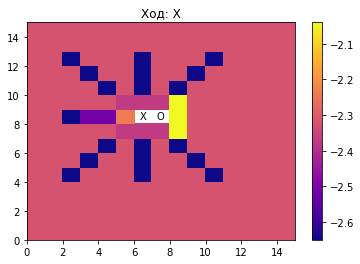

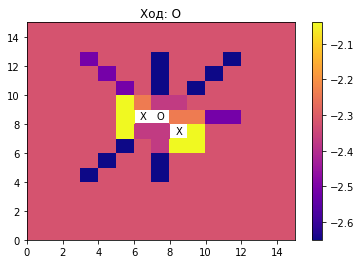

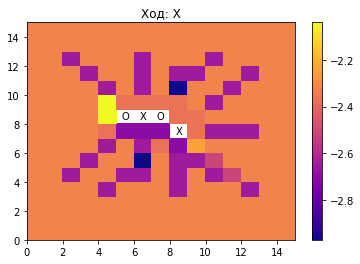

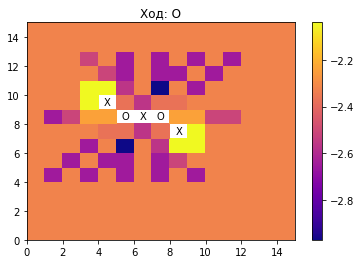

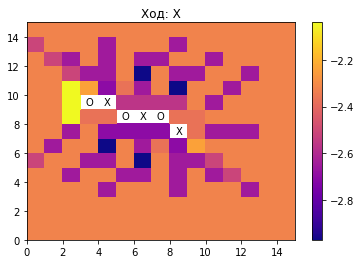

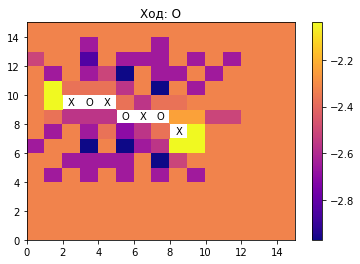

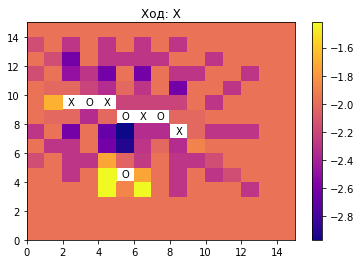

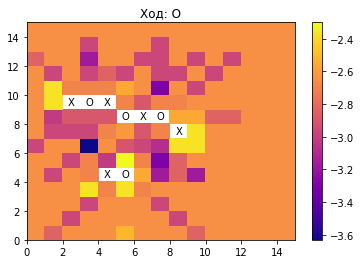

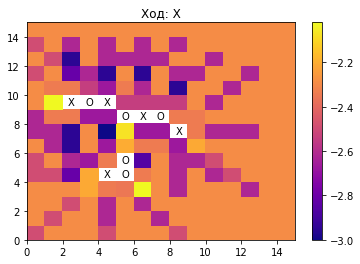

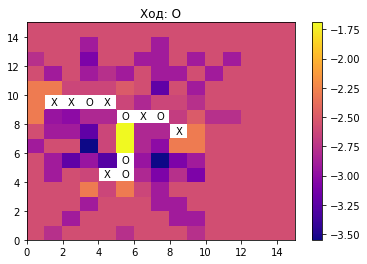

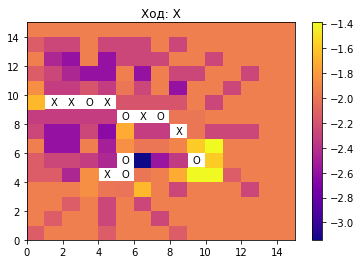

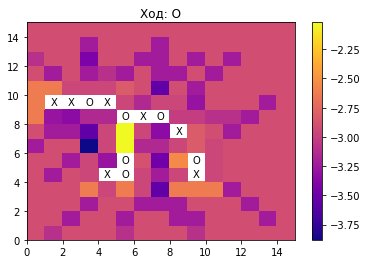

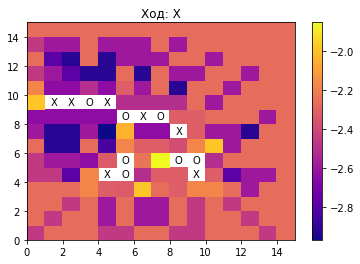

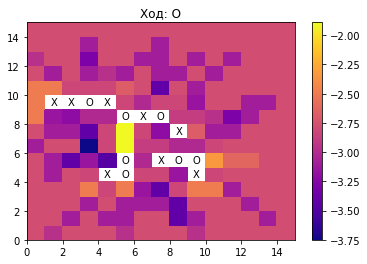

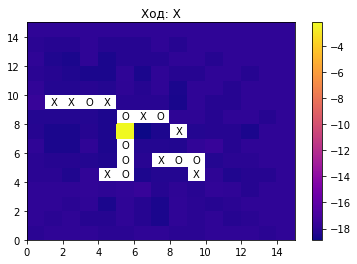

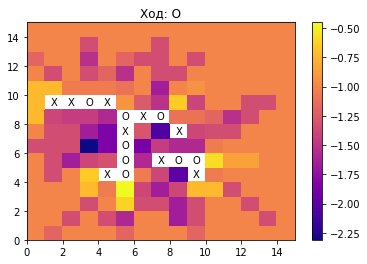

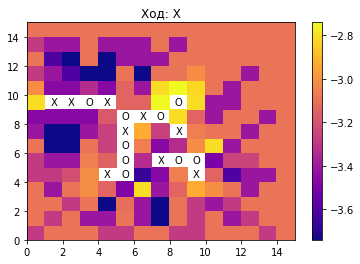

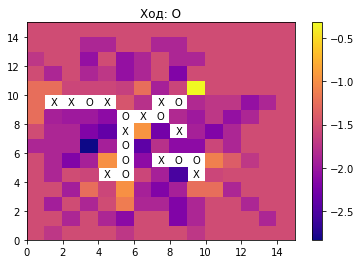

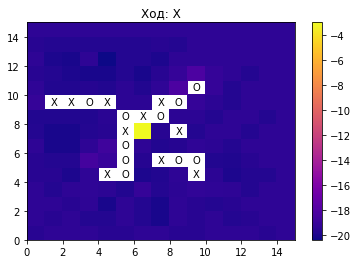

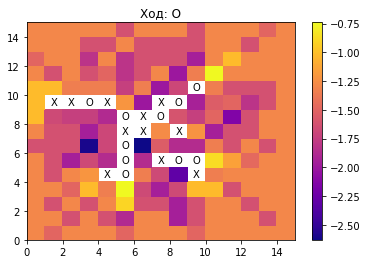

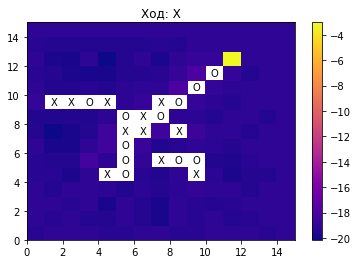

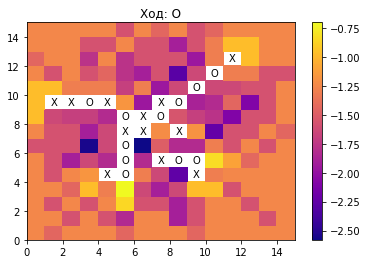

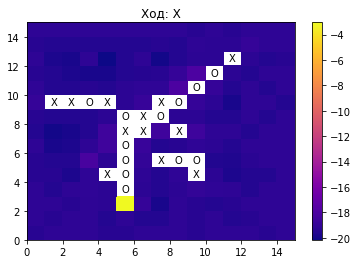

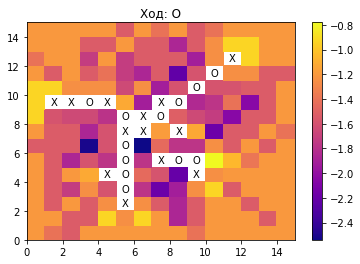

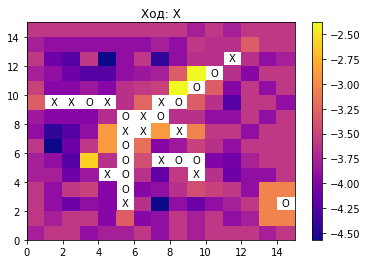

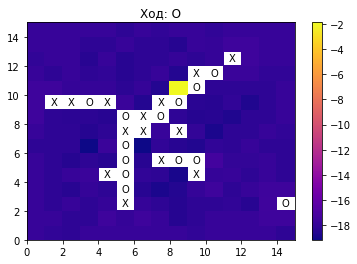

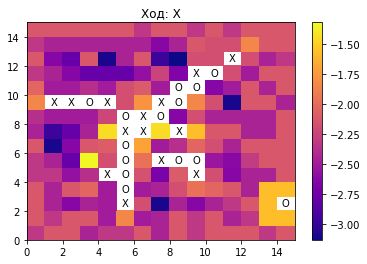

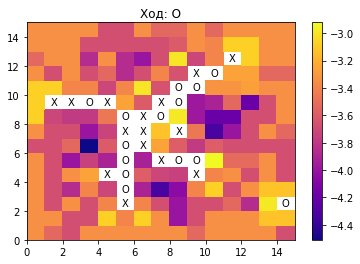

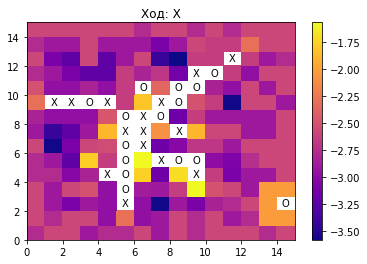

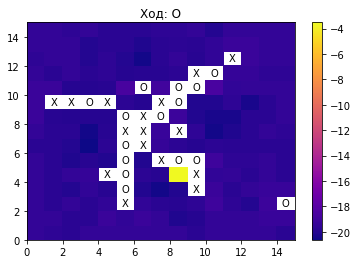

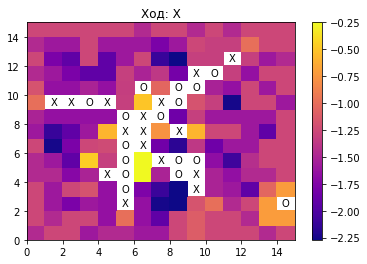

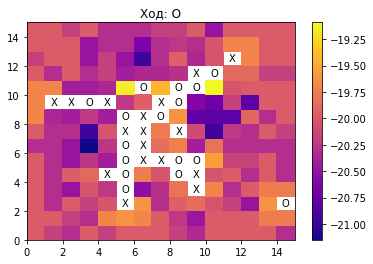

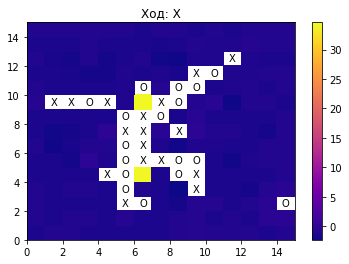

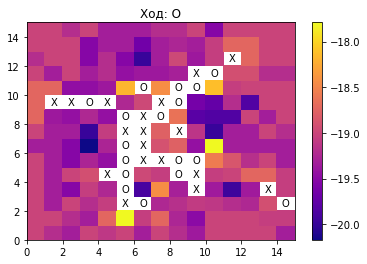

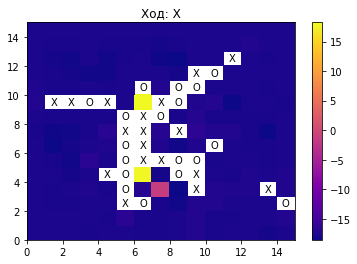

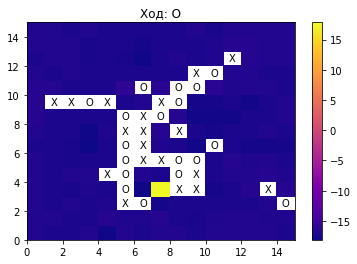

In [305]:
for i, qt in enumerate(q_tables):
    heatmap_q_values(qt, states[i].current_player.name)

### TODO:
* UI переделать на jp_proxy_widget